# Feature Engineering

In [1]:
import sys
import pandas as pd
sys.path.append('../')
from utils.engineering import calculate_distance, Plots, statistical_tests, saving_dataset
import warnings
warnings.filterwarnings("ignore")

# Data

In [2]:
df = pd.read_csv("./Data/clean_teste_indicium_precificacao.csv")
print(f"Shape: {df.shape}")
df.head()

Shape: (47169, 12)


,nome,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,Skylit Midtown Castle,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
1,THE VILLAGE OF HARLEM....NEW YORK !,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
2,Entire Apt: Spacious Studio/Loft by central park,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0
3,Large Cozy 1 BR Apartment In Midtown East,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,0.59,1,129
4,BlissArtsSpace!,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,0.40,1,0


# Feature Engineering

In [3]:
points_of_interest = {"times_square": (40.758896, -73.985130),
                      "central_park": (40.785091, -73.968285),
                      "empire_state": (40.7484053, -73.9856019)}
# Creating distance features for each point of interest
for name, coordinates in points_of_interest.items():
    df[f"distance_to_{name}"] = df.apply(lambda row: calculate_distance(row["latitude"], row["longitude"], coordinates), axis=1)

# Correlation Matrix

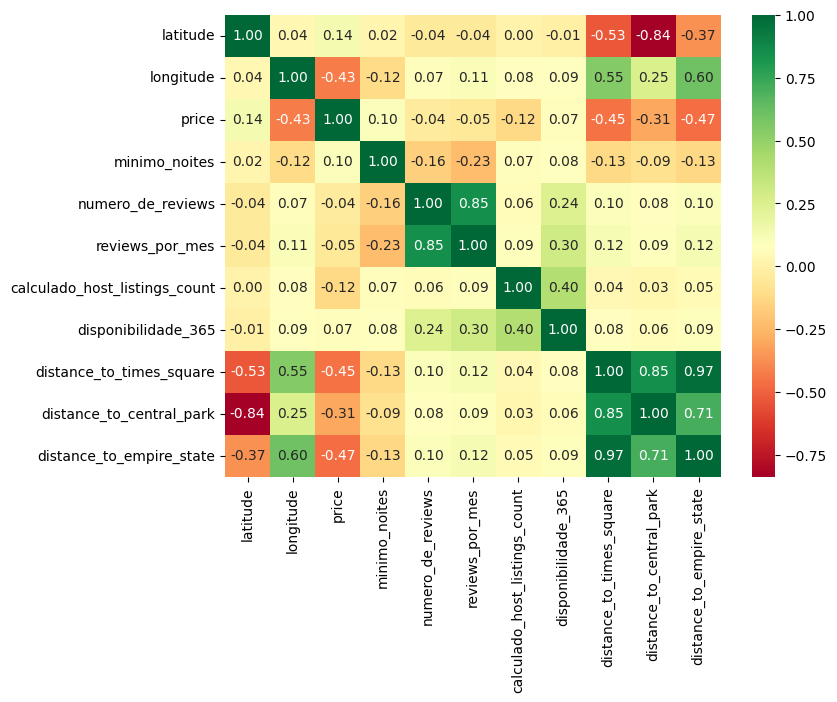

In [4]:
plotter = Plots(df)
plotter.plot_corr("spearman", (8, 6))

### Observations:
- The "spearman" method is used to make sure the correlation is robust against the outliers, and to handle non-linear relations
- `price` has a moderate negative correlation with `longitude` and all newly created distance features
- `calculado_host_listings_count` have a small negative correlation with `price`
- `disponibilidade_365` doesn't have any correlation with `price` and didn't show any form or relationship with it during the EDA
- All new features are heavily correlated, and the same can be said about `numero_de_reviews` and `reviews_por_mes`. This multicollinearity can introduce redundancy and instability to the model
### Impact:
- `calculado_host_listings_count` can be used to train the models
- `nome` and `disponibilidade_365` can be dropped, since they were used on the EDA and `disponibilidade_365` didn't show any form or relationship with `price`
- Statistical tests like **ANOVA** and **VIF** are needed to check multicollinearity between features and decide which ones to keep

In [9]:
df = df.drop(columns=["nome", "disponibilidade_365"])

# Statistical tests

### **F-regression** will measure the statistical importance of numerical features in predicting the target variable based on their linear relationship. If the p-value is below 0.05, the feature is considered statistically important
### **One-way** anova test will test whether the mean values of the target variable differ significantly across different groups of a categorical feature. The same rule of p-value applies to this test
### **VIF**  will measure the multicollinearity between numerical features. Features with a vif value above 5 should be considered to be removed

In [11]:
f_regression_results, f_oneway_results, vif_data = statistical_tests(df, "price")

In [12]:
f_regression_results

,Feature,F-Score,P-Value
0,latitude,228.207398,1.935646e-51
1,longitude,3631.006258,0.000000e+00
2,minimo_noites,35.489443,2.582495e-09
3,numero_de_reviews,95.296672,1.721317e-22
4,reviews_por_mes,93.500588,4.257325e-22
5,calculado_host_listings_count,820.848945,5.447299e-179
6,distance_to_times_square,5807.334955,0.000000e+00
7,distance_to_central_park,2721.611998,0.000000e+00
8,distance_to_empire_state,6080.369832,0.000000e+00


In [13]:
f_oneway_results

,Feature,p-value
0,bairro_group,0.0
1,bairro,0.0
2,room_type,0.0


In [14]:
vif_data[vif_data["VIF"] > 5]

,Feature,VIF
0,latitude,6.330971e+00
6,distance_to_times_square,2.413816e+02
7,distance_to_central_park,3.746163e+01
8,distance_to_empire_state,1.363849e+02
9,intercept,8.711099e+06


### Based on these results, all numerical and categorical features are statistically significant to the target. Also, all newly created features and `latitude` suffer from multicollinearity. To fix this, I decided to drop the columns `distance_to_central_park` and `distance_to_times_square`. `distance_to_empire_state` is being kept because it showed the highest correlation with the target and the lowest correlation with `latitude` and `longitude` out of all new features
### Regarding the reviews columns, I decided to drop `reviews_por_mes`, since it's derived from `numero_de_reviews`. Statistically speaking, both features are significant, but it's easier to interpret `numero_de_reviews`.

In [15]:
df = df.drop(columns=["reviews_por_mes", "distance_to_times_square", "distance_to_central_park"])

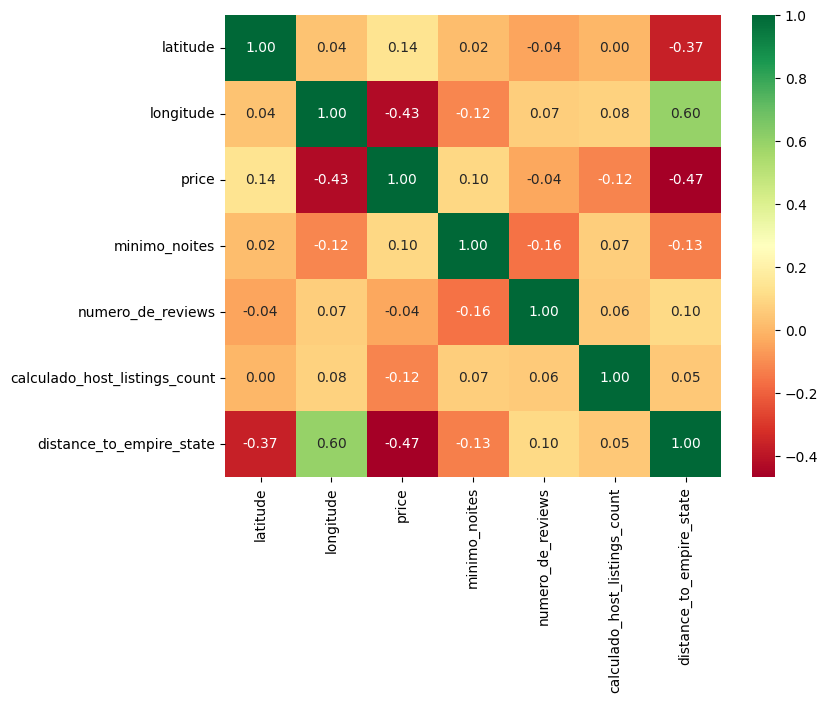

In [16]:
plotter = Plots(df)
plotter.plot_corr("spearman", (8, 6))

# Features Distributions

### As it was seen in the EDA, most numerical columns have a highly positive skewed distributions. Since the scaling and the models tend to have a better performance with normally distributed data, we can see which method of transformation is better for that specific column

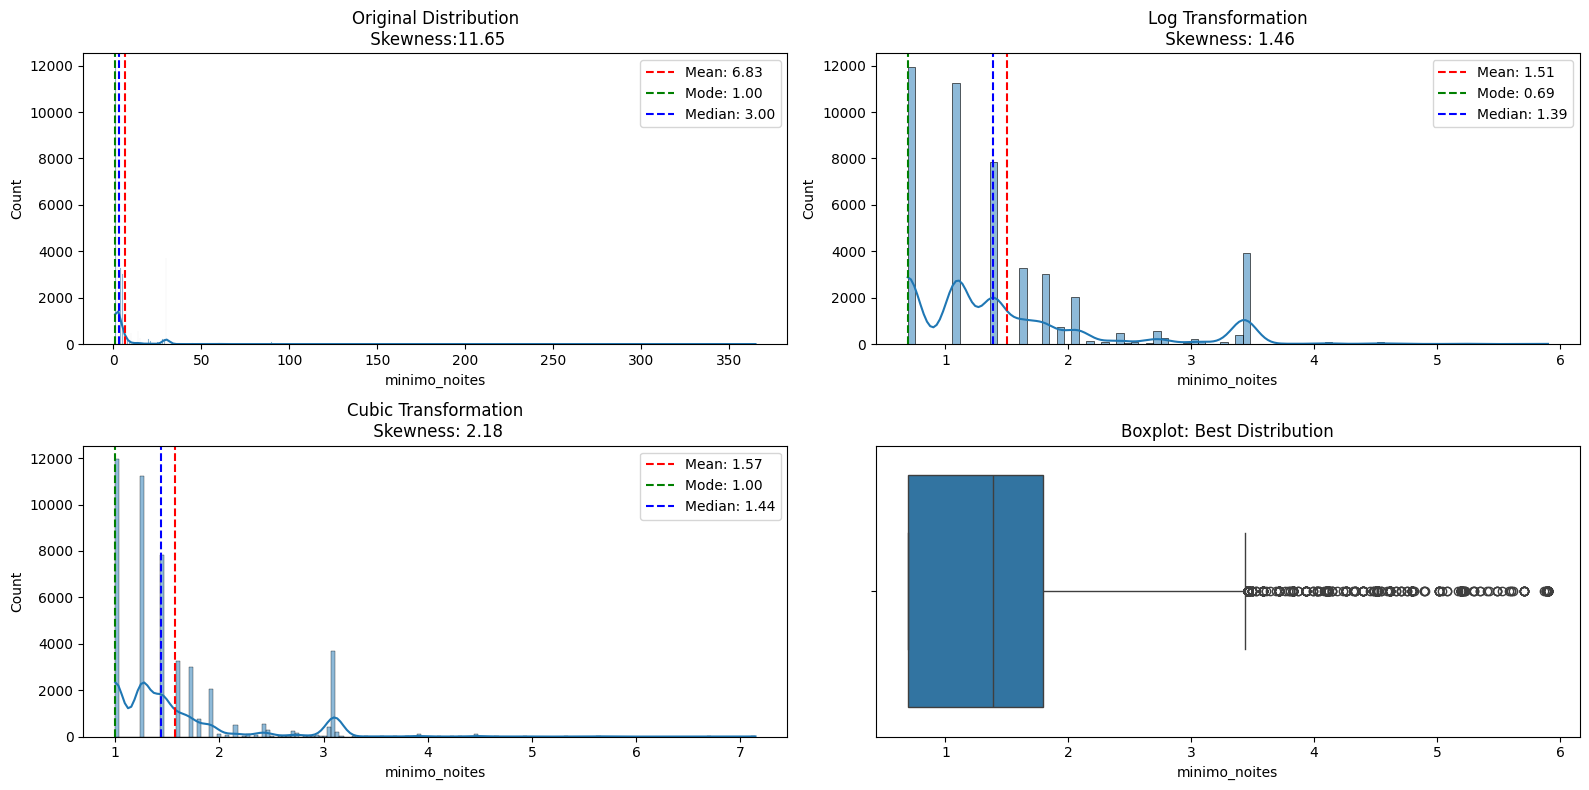

In [17]:
plotter.plot_transformed_distributions("minimo_noites")

### For `minimo_noites`, the log transformation is the best one, and there are still outliers

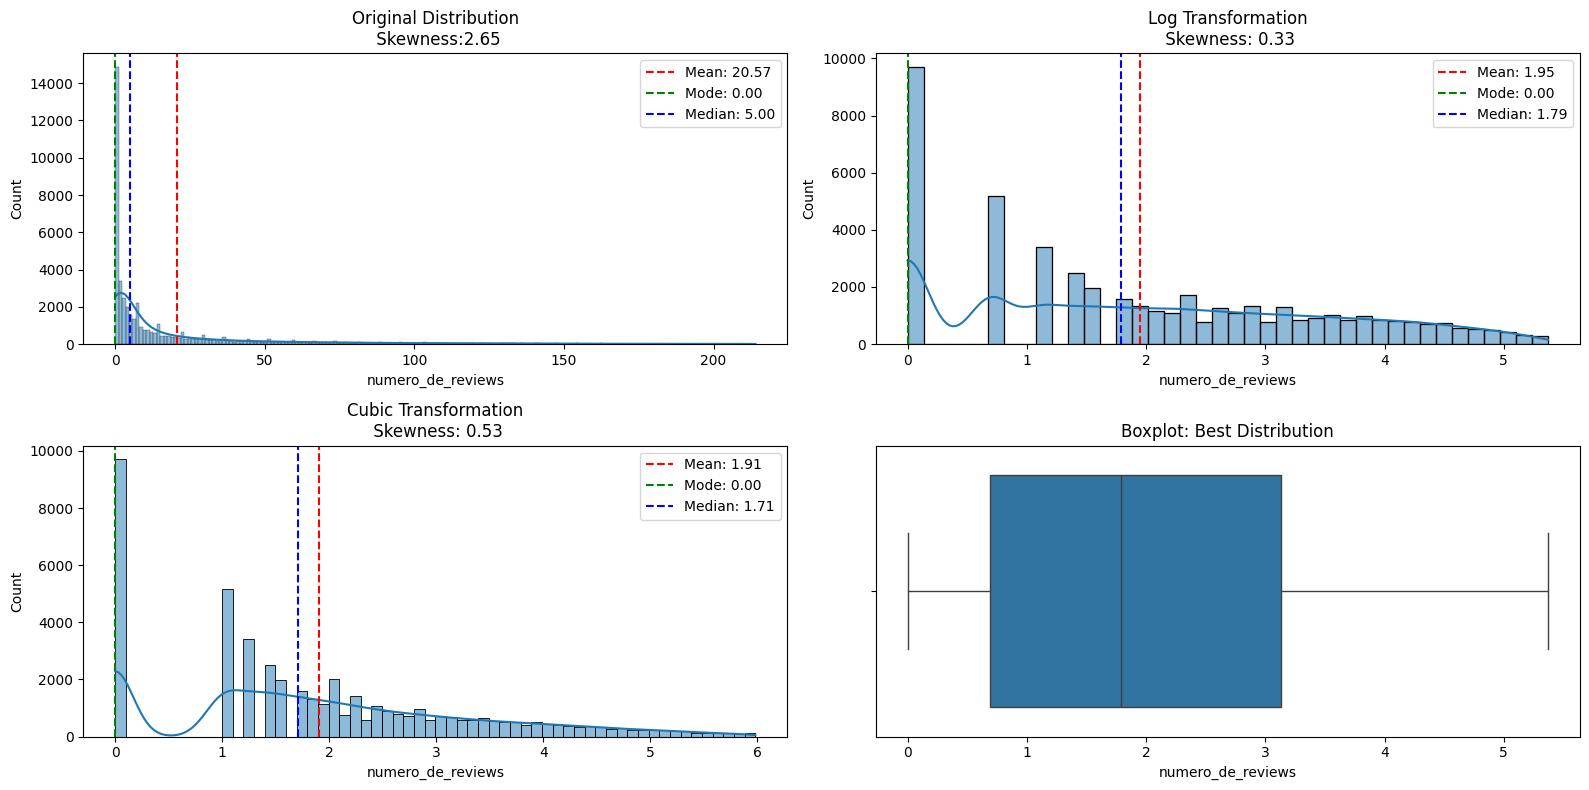

In [18]:
plotter.plot_transformed_distributions("numero_de_reviews")

### For `numero_de_reviews`, the log transformation is the best one, and there's no more outliers

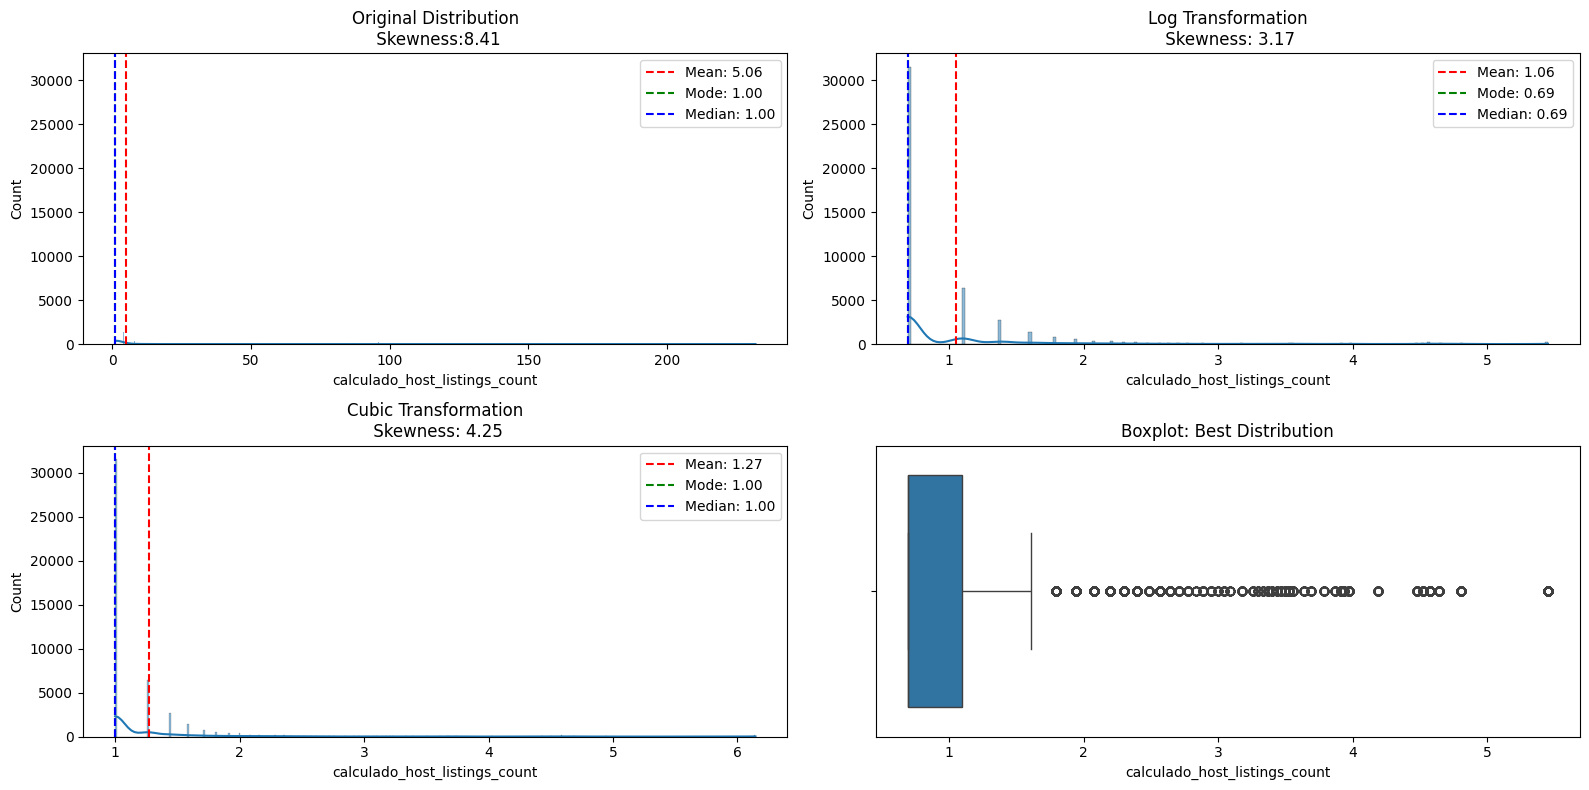

In [19]:
plotter.plot_transformed_distributions("calculado_host_listings_count")

### For `calculado_host_listings_count`, the log transformation is the best one, but there's a lot of outliers still

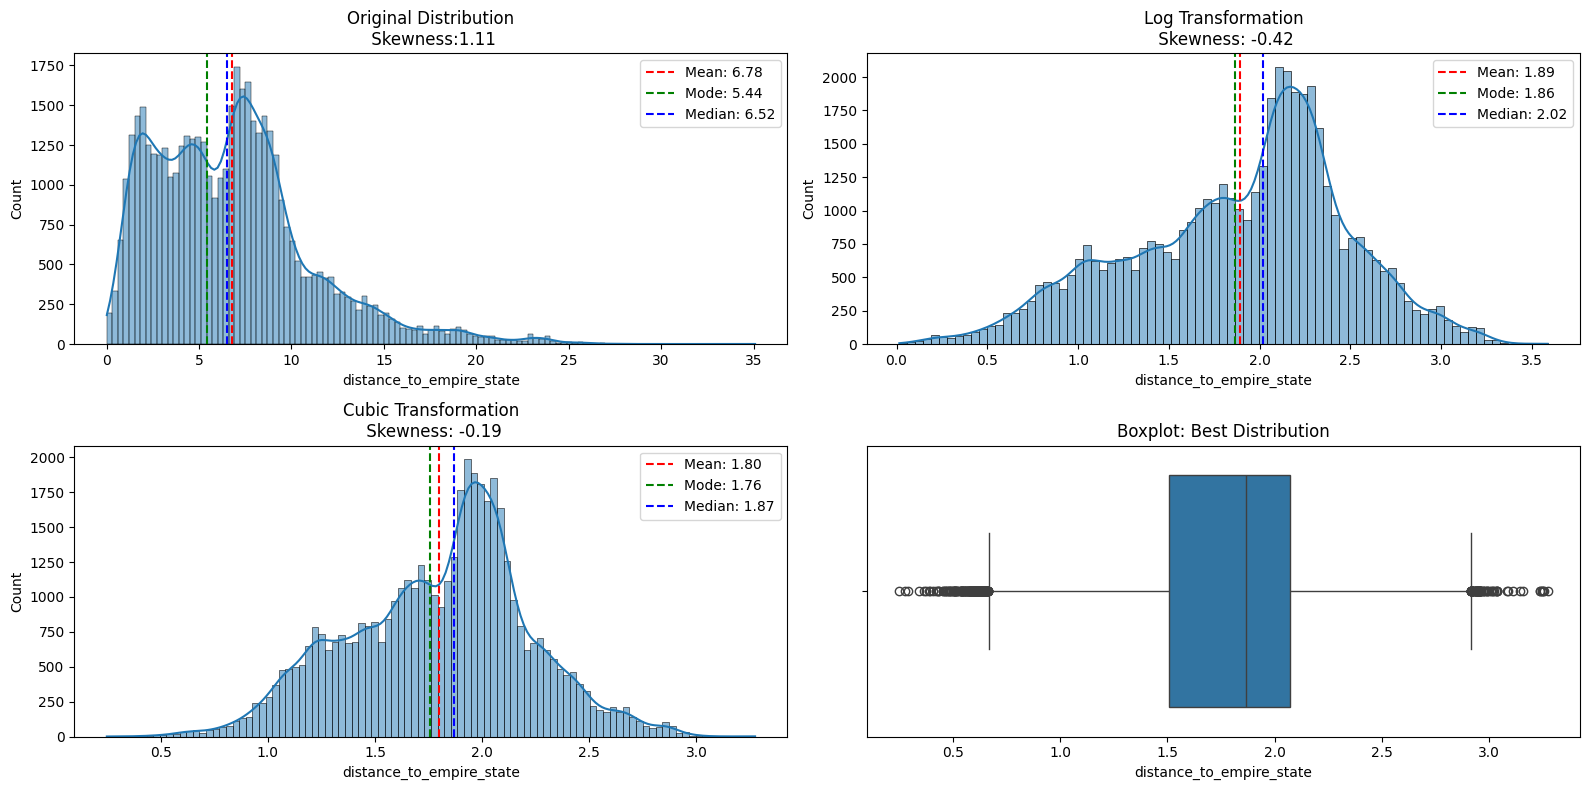

In [21]:
plotter.plot_transformed_distributions("distance_to_empire_state")

### For `distance_to_empire_state`, the cubic root transformation is the best one, and there's a few outliers

# Saving the file

In [25]:
df.head()

,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,calculado_host_listings_count,distance_to_empire_state
0,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2,0.600689
1,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,1,7.687548
2,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,1,6.588923
3,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,1,0.897823
4,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,1,7.291151


In [26]:
saving_dataset(df, "data", "model_training_dataset")